In [1]:
import argparse
import torch
import os

from PIL import Image

import os
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as T
from tqdm.notebook import tqdm

transform = T.ToPILImage()
import torch.optim as optim
import json
import numpy as np
import torch.nn.functional as F
import torchaudio
import torch.nn as nn
import imagebind.data as data
from IPython.display import Audio



/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' m

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:

from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

In [4]:

from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType



# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)
0

0

#### Convert MEL to Wav
This code is not accurate, i.e. wav->mel->wav does not really work
well, but it has acceptable quality.

In [147]:

import torch
import torchaudio
import torchaudio.transforms as T
from IPython.display import Audio


# Parameters
num_mel_bins = 128
num_frames = 204
sample_rate = 16000
n_fft = 400
hop_length = n_fft//4
win_length = n_fft

# Function to create a Mel inversion matrix
def create_mel_inversion_matrix(sr, n_fft, n_mels, fmin=0.0, fmax=None):
    # Create a Mel filter bank using torchaudio
    mel_fb = T.MelScale(n_mels, sr, f_min=fmin, f_max=fmax, n_stft=n_fft//2+1, norm=None)
    # Convert the filter bank to a tensor
    mel_fb_tensor = torch.tensor(mel_fb.fb, dtype=torch.float)
    # Calculate the pseudo inverse
    inversion_matrix = torch.pinverse(mel_fb_tensor)
    print(inversion_matrix.shape)
    
    return inversion_matrix

def inverse_it(mel_spectrogram):
    
    # Create the Mel inversion matrix
    inversion_matrix = create_mel_inversion_matrix(sample_rate, n_fft, num_mel_bins)

    # Invert the Mel spectrogram to a power spectrogram
    power_spectrogram = torch.matmul(mel_spectrogram, inversion_matrix)

    # Create an InverseMelScale transform
    inverse_mel_scale_transform = T.InverseMelScale(
        n_stft=n_fft//2+1,
        n_mels=num_mel_bins,
        sample_rate=sample_rate,
        f_min=0.0,
        f_max=sample_rate//2,
        norm=None
    )

    # Apply the InverseMelScale transform to the Mel spectrogram
    spectrogram = inverse_mel_scale_transform(mel_spectrogram.T)

    # Initialize Griffin-Lim transform
    griffin_lim = T.GriffinLim(n_fft=n_fft, n_iter=32, win_length=win_length, hop_length=hop_length)

    # Recover the waveform from the spectrogram
    recovered_waveform = griffin_lim(spectrogram)
    
    Audio(recovered_waveform, rate=16000)
    
    return recovered_waveform

def inverse_normalize(melspec, mean=-4.268, std=9.138):
    return melspec * std + mean


def combine_results(audio):
    results = list()
    for i in range(audio.shape[1]):
        res = inverse_it(inverse_normalize(audio.clone().detach().cpu().float()[0][i][0]).T)
        results.append(res)
    return [results[0], results[1], results[2]]
    # return [results[0][:-5000], results[1][:-5000], results[2][:-2000]]
    
from pydub import AudioSegment
import os

def get_results(audio_tensor):
    mel_spectrogram_np = audio_tensor[0, :, 0, :, :198].detach().clone().cpu().float()
    audio_cropped = torch.cat(tuple(mel_spectrogram_np), dim=-1)
    return inverse_it(inverse_normalize(audio_cropped.T))


def convert_mp3_to_wav(input_path, output_path, bitrate, duration, shift=0):
    # Load the MP3 file
    audio = AudioSegment.from_mp3(input_path)
    print(len(audio))
    # Set the desired duration
    audio = audio[shift:duration * 1000 + shift]

    # Set the desired bitrate
    audio = audio.set_frame_rate(bitrate)

    # Export the audio as a WAV file
    audio.export(output_path, format='wav')
    return audio

def plot_mel(spectrogram_tensor):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Assuming `spectrogram_tensor` is your tensor of shape torch.Size([1, 3, 1, 128, 204])
    
    # Convert PyTorch tensor to numpy array
    spectrogram_np = spectrogram_tensor.numpy()
    
    # Squeeze the array to remove singleton dimensions and select one channel
    spectrogram_np_squeezed = np.squeeze(spectrogram_np)[0]
    
    # Plotting the spectrogram
    plt.figure(figsize=(5, 4))
    plt.imshow(spectrogram_np_squeezed, aspect='auto', origin='lower')
    plt.title('Mel spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

 

In [167]:
# Provide the input MP3 file path, output WAV file path, bitrate, and duration
input_file = 'all_assets/YOUR_FILE.mp3'
output_file = 'all_assets/YOUR_FILE.wav'
bitrate = 16000  # 16 kHz
duration = 10  # 10 seconds

# Convert the MP3 to WAV
audio = convert_mp3_to_wav(input_file, output_file, bitrate, duration, shift=000)
audio

32341


In [169]:
path = "/home/eugene/ImageBind/.assets/dog_audio.wav"
orig_waveform, sr = torchaudio.load(path)
Audio(orig_waveform, rate=sr)

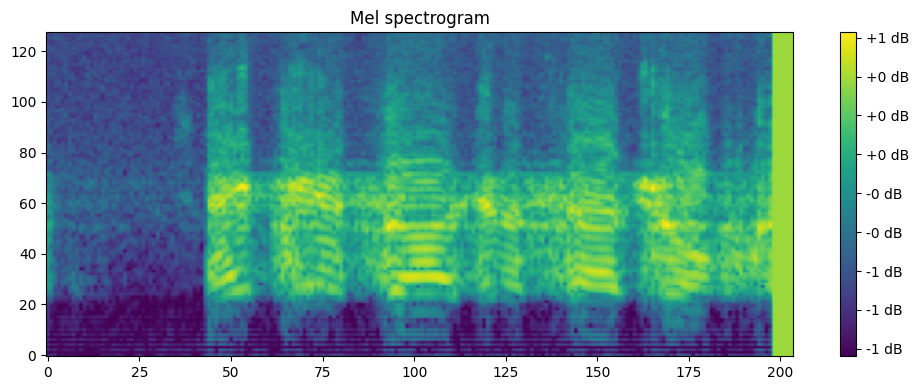

In [37]:
plot_mel(audio_tensor.detach().cpu())

In [172]:
text_list=['A classical music concert',]
# image_paths=[".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]
# image_paths = ['all_assets/dragon.jpg',]
# audio_paths=[".assets/bird_audio.wav"] # ".assets/car_audio.wav", ".assets/bird_audio.wav"

# Load data
inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, device),
    # ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

with torch.no_grad():
    text_embed = model.forward( {ModalityType.TEXT: data.load_and_transform_text(text_list, device)}, normalize=False)[ModalityType.TEXT] 
    # audio_embed = model.forward( {ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device)}, normalize=True)[ModalityType.AUDIO]
    # image_embed = model.forward({ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device)}, normalize=False)[ModalityType.VISION]

ideal_embed = text_embed.clone()

# Attack

In [173]:
X = 0.0001 * torch.rand_like(audio_tensor).to(device)
X.requires_grad_(True)
audio_tensor = audio_tensor.to(device)
0

0

In [174]:
epochs = 20000
optimizer = optim.SGD([X], lr=0.005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                              T_max = epochs, # Maximum number of iterations.
                              eta_min = 1e-5) # Minimum learning rate.

In [175]:
pbar = tqdm(range(epochs))
saved_dict = dict()

for i in pbar:
    lr = scheduler.get_last_lr()[0]

    embeds = model.forward({'audio': X + audio_tensor}, normalize=True)
    
    # use cosine similarity
    loss = 1 - F.cosine_similarity(embeds['audio'], ideal_embed, dim=1).mean()
    grads = torch.autograd.grad(outputs=loss, inputs=X)
    
    X = X - lr * grads[0].sign()

    # clamp amount of perturbation
    X.detach().clamp_(min=-0.05, max=0.05)

    
    pbar.set_postfix({'loss': loss.item(), 'lr': lr, 'norm': X.detach().norm().item(), 'saved': list(saved_dict.keys())})
    scheduler.step()
    del grads, embeds, loss
    

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/eugene/miniconda3/envs/imagebind/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [144]:
torch.save((X + audio_tensor).detach().cpu(), f'hack/results.pt')

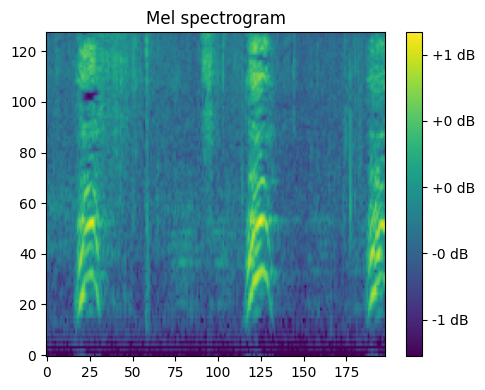

In [177]:
plot_mel((X + audio_tensor).detach().cpu()[:,:,:,:,:-6])
